In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import causallearn
import re

from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import io
import os
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib as mp
from matplotlib.ticker import FuncFormatter

In [2]:
import csv

def process_csv_file(filename, num_cores):
    ipc_data = [[] for _ in range(num_cores)]
    misses_data = [[] for _ in range(num_cores)]
    llc_data = [[] for _ in range(num_cores)]
    mbl_data = [[] for _ in range(num_cores)]
    mbr_data = [[] for _ in range(num_cores)]

    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        for row in reader:
            # Skip non-data rows
            if 'TIME' in row:
                continue

            for key, value in row.items():
                try:
                    data_parts = value.split()
                    current_core = int(data_parts[0])
                    if current_core < num_cores:
                        ipc_data[current_core].append(float(data_parts[1]))
                        misses_data[current_core].append(float(data_parts[2][:-1]) * 1000)
                        llc_data[current_core].append(float(data_parts[3]))
                        mbl_data[current_core].append(float(data_parts[4]))
                        mbr_data[current_core].append(float(data_parts[5]))
                except ValueError:
                    # Handle cases where conversion to int or float fails
                    pass

    return ipc_data, misses_data, llc_data, mbl_data, mbr_data


In [5]:
# user example
filename = '..\\way_allocated_sensitive\\l3fwd_pktsize_64.csv'
num_cores = 5
ipc, misses, llc, mbl, mbr = process_csv_file(filename, num_cores)

# cache miss comparision -l3fwd-pktsize

In [7]:
#vnfs="l3fwd"
params= ["64", "128", "256", "512", "1024", "1510"]
num_cores = 5
vnfs="l3fwd"
# Dictionary to store the results for each file
results = {}
for param in params:
    filename =  f'..\\way_allocated_sensitive\\{vnfs}_pktsize_{param}.csv'
    ipc, misses, llc, mbl, mbr = process_csv_file(filename, num_cores)
    results[param] = {
        'ipc': ipc,
        'misses': misses,
        'llc': llc,
        'mbl': mbl,
        'mbr': mbr
    }


In [8]:
print(results["64"]["misses"][2])

[8000.0, 16000.0, 16000.0, 10000.0, 5000.0, 108000.0, 4000.0, 75000.0, 67000.0, 65000.0, 9000.0, 62000.0, 10000.0, 8000.0, 3000.0, 0.0, 0.0, 33000.0, 44000.0, 39000.0, 37000.0, 29000.0, 31000.0, 34000.0, 27000.0, 27000.0, 29000.0, 3000.0, 29000.0, 5000.0, 31000.0, 0.0, 32000.0, 33000.0, 0.0, 0.0, 0.0, 26000.0, 23000.0, 0.0, 31000.0, 29000.0, 24000.0, 30000.0, 26000.0, 27000.0, 22000.0, 21000.0, 27000.0, 0.0, 23000.0, 27000.0, 24000.0, 22000.0, 23000.0, 26000.0, 0.0, 18000.0, 0.0, 23000.0, 24000.0, 23000.0, 0.0, 19000.0, 22000.0, 22000.0, 23000.0, 0.0, 23000.0, 21000.0, 0.0, 18000.0, 19000.0, 22000.0, 0.0, 12000.0, 15000.0, 26000.0, 18000.0, 18000.0, 18000.0, 15000.0, 22000.0, 20000.0, 21000.0, 18000.0, 0.0, 17000.0, 23000.0, 0.0, 16000.0, 16000.0, 17000.0, 17000.0, 17000.0, 17000.0, 3000.0, 18000.0, 22000.0, 0.0, 16000.0, 18000.0, 33000.0, 19000.0, 16000.0, 0.0, 20000.0, 16000.0, 21000.0, 0.0, 15000.0, 19000.0, 17000.0, 18000.0, 21000.0, 15000.0, 20000.0, 10000.0, 24000.0, 13000.0, 0.0

In [9]:
import matplotlib.pyplot as plt

data={}
params= ["64", "128", "256", "512", "1024", "1510"]

for param in params:
    #data[param]=np.sum(results[param]['misses'],axis=0)
    data[param]=results[param]['misses'][0]+results[param]['misses'][1]+results[param]['misses'][2]+results[param]['misses'][3]

In [25]:
print(np.mean(results["64"]['misses'][1]))

25872.442396313363


In [26]:
print(np.mean(results["128"]['misses'][1]))

14010.008725555612


In [32]:
print(np.mean(results["256"]['misses'][0]))

132869.5652173913


In [28]:
print(np.mean(results["512"]['misses'][1]))

7494.513533284565


In [29]:
print(np.mean(results["1024"]['misses'][1]))

9929.976658886295


In [30]:
print(np.mean(results["1510"]['misses'][1]))

12843.651494136931


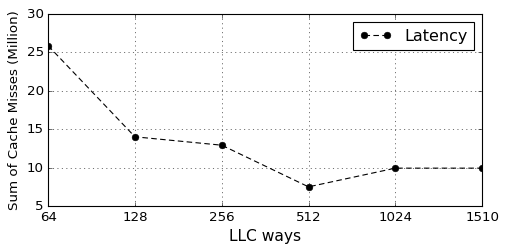

In [33]:
fig, ax = plt.subplots(facecolor='white', figsize=(7,3))
plt.style.use('classic')
xx = ["64", "128", "256", "512", "1024", "1510"]
data_contention=[25872,14010,12917,7494,9929,9929]
#xx=[1,2,4,20]
ax.plot(xx,[i/1000 for i in data_contention], marker='o', markersize=6, c='k', linestyle='-', linewidth=1, dashes=(5, 3), label="Latency")
ax.set_xlabel(f'LLC ways', size='14')
ax.set_ylabel("Sum of Cache Misses (Million)", size='12')
ax.legend(loc='upper right')
#ax.set_ylim([0,6])
ax.grid()
#save figure
folder_path = '..\\figure\\ndpi'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
file_path = os.path.join(folder_path, f'llc_latency.pdf' )

plt.show()